In [2]:
import pandas as pd
from sklearn.metrics import matthews_corrcoef, confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import os
from evaluate import load #https://pypi.org/project/evaluate/ & https://huggingface.co/spaces/evaluate-metric/wer
from datasets import load_metric


2024-02-06 16:43:23.793121: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-06 16:43:25.639248: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


# Part 1: Compute Word Error Rate (WER)

In [13]:
# input, set this variable:
asrModel = 'whispert' #'whispert' or 'ctc_kurz_w2v_fc'

manualTransFile = '/vol/tensusers2/wharmsen/SERDA-annotations/round1_stories_all_11jan/02_json/asr-transcriptions.tsv'
manualTransDF = pd.read_csv(manualTransFile, sep='\t', header=None).drop_duplicates()
manualTransDF.columns = ['filename', 'manual_transcript']
manualTransDF = manualTransDF.set_index('filename')

asrTransFile = '/vol/tensusers2/wharmsen/SERDA-experiment-data/round1/stories_manann_11jan/'+ asrModel +'/csv-alignments/asr-transcriptions.tsv'
asrTransDF = pd.read_csv(asrTransFile, sep='\t').drop_duplicates()
asrTransDF.columns = ['filename', 'asr_transcript']
asrTransDF = asrTransDF.set_index('filename')

combinedDF = pd.concat([manualTransDF, asrTransDF], axis=1).dropna(axis=0)

def computeWER(row):
    wer = load("wer")
    ref = [row['manual_transcript']]
    hyp = [row['asr_transcript']]

    return wer.compute(predictions=hyp, references=ref)

def computeWER2(row):
    wer_metric=load_metric('wer')
    ref = [row['manual_transcript']]
    hyp = [row['asr_transcript']]

    return wer_metric.compute(predictions=ref, references=hyp)

def computeCER(row):
    cer_metric=load_metric('cer')
    ref = [row['manual_transcript']]
    hyp = [row['asr_transcript']]

    return cer_metric.compute(predictions=ref, references=hyp)

combinedDF['WER'] = combinedDF.apply(computeWER, axis=1)
combinedDF['WER2'] = combinedDF.apply(computeWER2, axis=1)
combinedDF['CER'] = combinedDF.apply(computeCER, axis=1)

print("asrModel:", asrModel)
combinedDF.describe()

/tmp/ipykernel_1617773/2660640762.py:24: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  wer_metric=load_metric('wer')


asrModel: whispert


,WER,WER2,CER
count,5.000000,5.000000,5.000000
mean,0.597396,0.984801,0.504945
std,0.026662,0.090392,0.077207
min,0.560000,0.884956,0.413249
25%,0.584795,0.933333,0.466867
50%,0.596685,0.972973,0.496148
75%,0.622549,1.008850,0.527822
max,0.622951,1.123894,0.620640


In [15]:
list(combinedDF['manual_transcript']) 

['bang in uh donker als de beker vol is doet mar-te de kraan dicht nu moet je echt gaan slapen zeg mama je was al drie keer uit bed ben je niet blij met je eigen slaapkamer marte voelt haar wangen warm worden jawel ik vind hartstikke mooi ze draait zich om en loopt langzaam de zoldertrap op de traptreden kraken onder haar blote voeten het ies een naar geluid dat ze nog nooi-it eerder heeft gehoord als klinkt een beetje anders in t donker de deur van haar slaapkamer staat op een kier het lampje boven haar bed brandt en maakt ee vreemde vlek op de muur haar oude knuffelbeer staat op het kastje met de vlek op de lampt op de muur erachter lijkt op een monster marte en rilt en kruipt snel onder de dekens niet bang zijn het wordt gewoon haar eigen knuffelbeer maar haar hart bonkst in de keel voor het eerst heef ze een eig kamer op zolder tot gister sliep ze altijd < bij haar > met haar broer broer hidde op een kamer',
 'versaald als ouders zien dat je veel aan het gaamen be gaa gaamen bent d

In [16]:
combinedDF['WER'].mean()

0.5973960487580658

In [8]:
import alignment_adagt.adagt as adagt
adagt.align_dist('hallo', 'halo', 'normal') #dist_score, nsub, ndel, nins, alnorm, alreal

(1.0, 0, 1, 0, 'hallo', 'ha*lo')

In [11]:
import alignment_adapt.adapt as adapt
adapt.align_dist('h|E|t', 'h|@|t') #dist_score, nsub, ndel, nins, alnorm, alreal

(2.0, 1, 0, 0, 'h|E|t', 'h|@|t')

In [53]:
combinedDF.loc['ZDPNZ-story_1-20221107124621000', 'manual_transcript']

'bang in uh donker als de beker vol is doet mar-te de kraan dicht nu moet je echt gaan slapen zeg mama je was al drie keer uit bed ben je niet blij met je eigen slaapkamer marte voelt haar wangen warm worden jawel ik vind hartstikke mooi ze draait zich om en loopt langzaam de zoldertrap op de traptreden kraken onder haar blote voeten het ies een naar geluid dat ze nog nooi-it eerder heeft gehoord als klinkt een beetje anders in t donker de deur van haar slaapkamer staat op een kier het lampje boven haar bed brandt en maakt ee vreemde vlek op de muur haar oude knuffelbeer staat op het kastje met de vlek op de lampt op de muur erachter lijkt op een monster marte en rilt en kruipt snel onder de dekens niet bang zijn het wordt gewoon haar eigen knuffelbeer maar haar hart bonkst in de keel voor het eerst heef ze een eig kamer op zolder tot gister sliep ze altijd < bij haar > met haar broer broer hidde op een kamer'

In [46]:
pred=['hao']
ref=['hallo']

In [47]:
from datasets import load_metric
wer_metric=load_metric('wer')
wer_metric.compute(predictions=pred, references=ref)

1.0

In [48]:
wer_metric=load_metric('cer')
wer_metric.compute(predictions=pred, references=ref)

0.4

In [36]:
wer = load("wer")
wer.compute(predictions=pred, references=ref)


0.4

# Part 2: Compute binary accuracy evaluation measures

Manual Accuracy Annotations (obtaied from Marlies & Julia TextGrids)

In [51]:
# Manual annotations (created using SERDA-annotation-repo/uber.sh)

# Input files
manualBasePath = '/vol/tensusers2/wharmsen/SERDA-annotations/round1_stories_all_11jan/03_accuracy_csv'
manualStory1File = os.path.join(manualBasePath, 'story1_manual_accuracy.csv')
manualStory2File = os.path.join(manualBasePath, 'story2_manual_accuracy.csv')
manualStory3File = os.path.join(manualBasePath, 'story3_manual_accuracy.csv')


# Read input files as dataframe
manualStory1DF = pd.read_csv(manualStory1File, index_col=0)
manualStory2DF = pd.read_csv(manualStory2File, index_col=0)
manualStory3DF = pd.read_csv(manualStory3File, index_col=0)


# Convert input files to numpy arrays
manualStory1 = manualStory1DF.to_numpy().flatten()
manualStory2 = manualStory2DF.to_numpy().flatten()
manualStory3 = manualStory3DF.to_numpy().flatten()

Automatic Accuracy Assessments

In [52]:
asrBasePath = '/vol/tensusers2/wharmsen/SERDA-experiment-data/round1/stories_manann_11jan/whispert/csv-scores'
# asrBasePath = '/vol/tensusers2/wharmsen/SERDA-experiment-data/round1/stories_manann_11jan/whispert_dis/csv-scores'
# asrBasePath = "/vol/tensusers2/wharmsen/SERDA-experiment-data/round1/stories_manann_11jan/ctc_kurz_w2v_fc/csv-scores"
asrStory1File = os.path.join(asrBasePath, 'story1AsrAccuracyDF.tsv')
asrStory2File = os.path.join(asrBasePath, 'story2AsrAccuracyDF.tsv')
asrStory3File = os.path.join(asrBasePath, 'story3AsrAccuracyDF.tsv')

asrStory1DF = pd.read_csv(asrStory1File, index_col=0, sep = '\t')
asrStory2DF = pd.read_csv(asrStory2File, index_col=0, sep = '\t')
asrStory3DF = pd.read_csv(asrStory3File, index_col=0, sep = '\t')

asrStory1 = asrStory1DF.to_numpy().flatten()
asrStory2 = asrStory2DF.to_numpy().flatten()
asrStory3 = asrStory3DF.to_numpy().flatten()

NameError: name 'pd' is not defined

For which speaker&task combination do we have manual annotations?

In [173]:
manualStory1DF.dropna()

,0-0-Bang,0-1-in,0-2-het,0-3-donker,1-0-Als,1-1-de,1-2-beker,1-3-vol,1-4-is,1-5-doet,...,19-2-sliep,19-3-ze,19-4-altijd,19-5-met,19-6-haar,19-7-broer,19-8-Hidde,19-9-op,19-10-een,19-11-kamer
SMVCS,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
XSWMB,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
YVBRP,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0
Z2BYD,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
ZDPNZ,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [174]:
asrStory1DF.dropna()

,0-0-Bang,0-1-in,0-2-het,0-3-donker,1-0-Als,1-1-de,1-2-beker,1-3-vol,1-4-is,1-5-doet,...,19-2-sliep,19-3-ze,19-4-altijd,19-5-met,19-6-haar,19-7-broer,19-8-Hidde,19-9-op,19-10-een,19-11-kamer
SMVCS,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
XSWMB,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
YHTKC,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,...,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
YKKTR,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
YVBRP,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
Z2BYD,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,...,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
ZDPNZ,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
ZNNGY,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
ZPGND,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
ZRYSY,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0


In [175]:
manualStory2DF.dropna()

,0-0-Jojo,1-0-Met,1-1-twee,1-2-doppen,1-3-van,1-4-een,1-5-fles,1-6-kun,1-7-je,1-8-bijvoorbeeld,...,17-12-maken,18-0-Hij,18-1-loopt,18-2-door,18-3-de,18-4-klas,18-5-en,18-6-bekijkt,18-7-alle,18-8-jojos
QPPY5,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
VJCMQ,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
YWPWY,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0
Z2BYD,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0
ZMQG2,0.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
ZQV5W,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,...,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0


In [176]:
asrStory2DF.dropna()

,0-0-Jojo,1-0-Met,1-1-twee,1-2-doppen,1-3-van,1-4-een,1-5-fles,1-6-kun,1-7-je,1-8-bijvoorbeeld,...,17-12-maken,18-0-Hij,18-1-loopt,18-2-door,18-3-de,18-4-klas,18-5-en,18-6-bekijkt,18-7-alle,18-8-jojos
QPPY5,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0
VJCMQ,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
YJ3PN,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0
YMRDV,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
YWPWY,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
Z2BYD,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0
ZDPNZ,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0
ZMQG2,0.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0
ZQV5W,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ZRYSY,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0


In [177]:
manualStory3DF.dropna()

,0-0-Verslaafd,1-0-Als,1-1-ouders,1-2-zien,1-3-dat,1-4-je,1-5-veel,1-6-aan,1-7-het,1-8-gamen,...,11-1-wel,11-2-over,11-3-het,11-4-spel,11-5-dat,11-6-je,11-7-aan,11-8-het,11-9-spelen,11-10-bent
QTB2S,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
WHHXX,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
YVBRP,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0
YWPWY,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0
ZNNGY,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
ZPGND,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0


In [178]:
asrStory3DF.dropna()

,0-0-Verslaafd,1-0-Als,1-1-ouders,1-2-zien,1-3-dat,1-4-je,1-5-veel,1-6-aan,1-7-het,1-8-gamen,...,11-1-wel,11-2-over,11-3-het,11-4-spel,11-5-dat,11-6-je,11-7-aan,11-8-het,11-9-spelen,11-10-bent
QTB2S,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
WHHXX,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
YKGD3,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
YQFGF,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
YVBRP,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
YWPWY,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ZMQG2,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ZNNGY,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ZPGND,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ZQV5W,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [179]:
list(manualStory3DF.dropna().index)


['QTB2S', 'WHHXX', 'YVBRP', 'YWPWY', 'ZNNGY', 'ZPGND']

FIle-level MCC measures

In [180]:
# from performance_metrics import getEvaluationMetrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, matthews_corrcoef, roc_auc_score, confusion_matrix, f1_score


def getEvaluationMetrics(title, y_true, y_pred):

    size = "N=" + str(len(y_true))
    acc = "Acc=" + str(round(accuracy_score(y_true, y_pred),3))
    prec = "Prec=" + str(round(precision_score(y_true, y_pred),3))
    recall = "Recall=" + str(round(recall_score(y_true, y_pred),3))
    f1 = "F1=" + str(round(f1_score(y_true, y_pred),3))
    mcc = "MCC=" + str(round(matthews_corrcoef(y_true, y_pred),3))
    auc = "AUC=" + str(round(roc_auc_score(y_true, y_pred),3))

    return "    ".join([title, size, acc, prec, recall, f1, mcc, auc])

In [181]:
print('--- STORY 1 ---')
mw1 = pd.read_csv(manualStory1File, index_col=0).dropna()
aw1 = asrStory1DF.loc[list(mw1.index),:]

for (name, e1, e2) in zip(list(mw1.index), mw1.to_numpy(), aw1.to_numpy()):
    # print(name, 'MCC = ', matthews_corrcoef(e1, e2))
    print(getEvaluationMetrics(name, e1, e2))

print('\n--- STORY 2 ---')
mw1 = pd.read_csv(manualStory2File, index_col=0).dropna()
aw1 = asrStory2DF.loc[list(mw1.index),:]

for (name, e1, e2) in zip(list(mw1.index), mw1.to_numpy(), aw1.to_numpy()):
    # print(name, 'MCC = ', matthews_corrcoef(e1, e2))
    print(getEvaluationMetrics(name, e1, e2))

print('\n--- STORY 3 ---')
mw1 = pd.read_csv(manualStory3File, index_col=0).dropna()
aw1 = asrStory3DF.loc[list(mw1.index),:]

for (name, e1, e2) in zip(list(mw1.index), mw1.to_numpy(), aw1.to_numpy()):
    # print(name, 'MCC = ', matthews_corrcoef(e1, e2))
    print(getEvaluationMetrics(name, e1, e2))

--- STORY 1 ---
SMVCS    N=174    Acc=0.598    Prec=0.95    Recall=0.596    F1=0.733    MCC=0.113    AUC=0.606
XSWMB    N=174    Acc=0.655    Prec=0.981    Recall=0.638    F1=0.773    MCC=0.274    AUC=0.747
YVBRP    N=174    Acc=0.615    Prec=0.97    Recall=0.602    F1=0.743    MCC=0.198    AUC=0.686
Z2BYD    N=174    Acc=0.598    Prec=0.952    Recall=0.604    F1=0.739    MCC=0.049    AUC=0.552
ZDPNZ    N=174    Acc=0.586    Prec=0.937    Recall=0.574    F1=0.712    MCC=0.162    AUC=0.629

--- STORY 2 ---
QPPY5    N=180    Acc=0.561    Prec=0.931    Recall=0.566    F1=0.704    MCC=0.036    AUC=0.533
VJCMQ    N=180    Acc=0.811    Prec=0.878    Recall=0.606    F1=0.717    MCC=0.605    AUC=0.775
YWPWY    N=180    Acc=0.594    Prec=0.945    Recall=0.558    F1=0.702    MCC=0.257    AUC=0.683
Z2BYD    N=180    Acc=0.561    Prec=0.962    Recall=0.571    F1=0.717    MCC=-0.076    AUC=0.386
ZMQG2    N=180    Acc=0.689    Prec=0.976    Recall=0.597    F1=0.741    MCC=0.485    AUC=0.777
ZQV5W   

Confusion Matrix analysis

In [182]:
def removeNANvalues(manualArray, asrArray):
    print("Nr values with NAN:", len(manualArray), len(asrArray))
    manualArrayClean = []
    asrArrayClean = []
    for (e1, e2) in zip(manualArray, asrArray):
        if not np.isnan(e1) and not np.isnan(e2):
            manualArrayClean.append(int(e1))
            asrArrayClean.append(int(e2))
    print("Nr values without NAN:", len(manualArrayClean), len(asrArrayClean))
    return manualArrayClean, asrArrayClean

In [183]:
manualStoryCleanAll = []
asrStoryCleanAll = []

PERFORMANCE TASK 1
Nr values with NAN: 34278 34278
Nr values without NAN: 870 870
MCC = 0.1634726965093351
[[ 48  21]
 [318 483]]


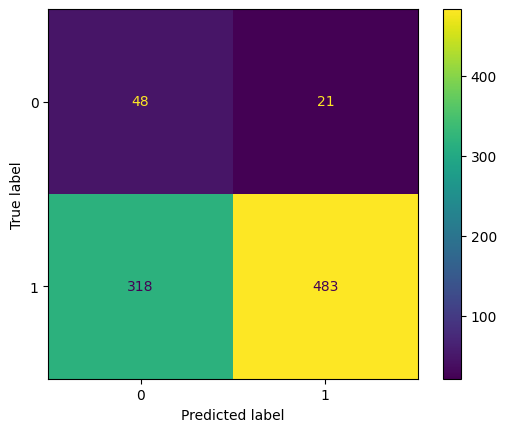

In [184]:
print("PERFORMANCE TASK 1")

manualStory = manualStory1
asrStory = asrStory1

manualStoryClean, asrStoryClean = removeNANvalues(manualStory, asrStory)
manualStoryCleanAll.extend(manualStoryClean)
asrStoryCleanAll.extend(asrStoryClean)
mcc = matthews_corrcoef(manualStoryClean, asrStoryClean)
mcc_story1 = str(round(mcc,3))
cm = confusion_matrix(manualStoryClean, asrStoryClean)
print('MCC =', mcc)
print(cm)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

PERFORMANCE TASK 2
Nr values with NAN: 35460 35460
Nr values without NAN: 1080 1080
MCC = 0.3809032889086343
[[214  28]
 [359 479]]


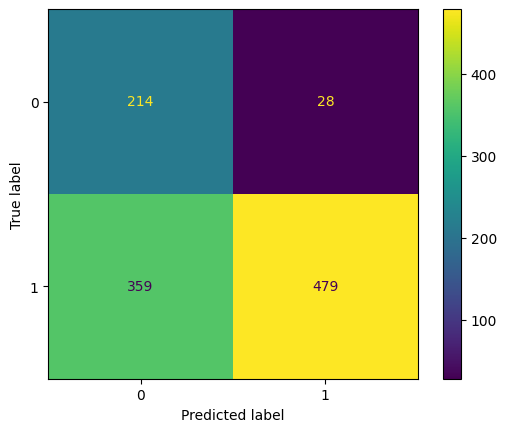

In [185]:
print("PERFORMANCE TASK 2")

manualStory = manualStory2
asrStory = asrStory2

manualStoryClean, asrStoryClean = removeNANvalues(manualStory, asrStory)
manualStoryCleanAll.extend(manualStoryClean)
asrStoryCleanAll.extend(asrStoryClean)
mcc = matthews_corrcoef(manualStoryClean, asrStoryClean)
mcc_story2 = str(round(mcc,3))
cm = confusion_matrix(manualStoryClean, asrStoryClean)
print('MCC =', mcc)
print(cm)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

PERFORMANCE TASK 3
Nr values with NAN: 33884 33884
Nr values without NAN: 1032 1032
MCC = 0.29877687613706
[[179  40]
 [368 445]]


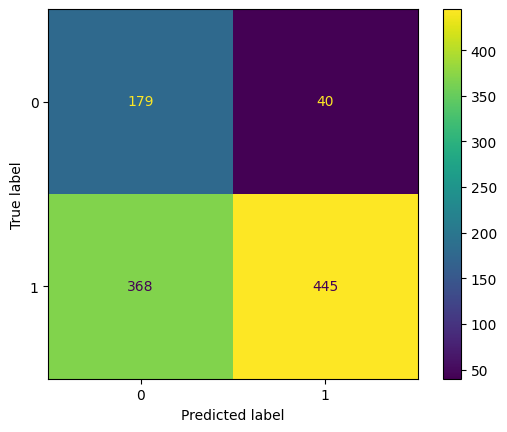

In [186]:
print("PERFORMANCE TASK 3")
manualStory = manualStory3
asrStory = asrStory3

manualStoryClean, asrStoryClean = removeNANvalues(manualStory, asrStory)
manualStoryCleanAll.extend(manualStoryClean)
asrStoryCleanAll.extend(asrStoryClean)
mcc = matthews_corrcoef(manualStoryClean, asrStoryClean)
mcc_story3 = str(round(mcc,3))
cm = confusion_matrix(manualStoryClean, asrStoryClean)
print('MCC =', mcc)
print(cm)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()


OVERALL PERFORMANCE
MCC = 0.3103375126804878
MCCstory1 = 0.163 	MCCstory2 = 0.381 	MCCstory3 = 0.299 	MCC_all_stories = 0.31
[[ 441   89]
 [1045 1407]]


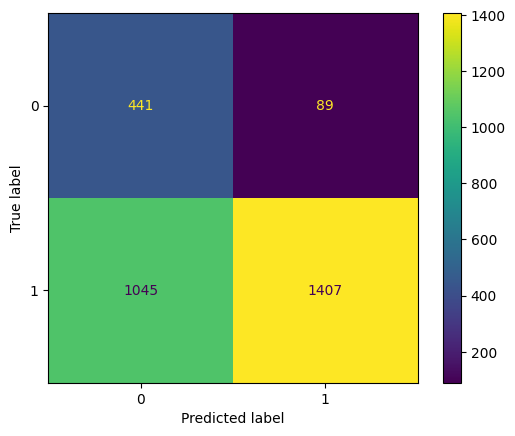

In [187]:
print("OVERALL PERFORMANCE")
mcc = matthews_corrcoef(manualStoryCleanAll, asrStoryCleanAll)
cm = confusion_matrix(manualStoryCleanAll, asrStoryCleanAll)
print('MCC =', mcc)
print("MCCstory1 =", mcc_story1, "\tMCCstory2 =", mcc_story2, "\tMCCstory3 =", mcc_story3, "\tMCC_all_stories =",str(round(mcc,3)))
print(cm)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

Error Analysis

In [76]:
import glob
import json
# Find the True label = 1 and Predicted label = 0 categories

mw = pd.read_csv(manualStory1File, index_col=0).dropna()
aw = asrStory1DF.loc[list(mw.index),:]
task = "story_1"

for studentID in aw.index:
    for prompt in aw.columns:
        predicted = aw.loc[studentID,prompt]
        actual = mw.loc[studentID,prompt]

        if(actual == 1 and predicted == 0):
            asrAlignmentPath = asrBasePath.replace("csv-scores", "csv-alignments")
            asrAlignmentFile = studentID + '-' + task + '*.csv'
            asrAlignmentPathAndFile = glob.glob(os.path.join(asrAlignmentPath, asrAlignmentFile))[0]
            alignDF = pd.read_csv(asrAlignmentPathAndFile, index_col=0)
            asrTrans1 = alignDF.loc[prompt, 'aligned_asrTrans']
            asrTrans2 = alignDF.loc[prompt, 'reversed_aligned_asrTrans']

            manualAlignmentPath = manualBasePath.replace("03_accuracy_csv", "02_json")
            manualAlignmentFile = studentID + '-' + task + '*.json'
            manualAlignmentPathAndFile = glob.glob(os.path.join(manualAlignmentPath, manualAlignmentFile))[0]
            with open(manualAlignmentPathAndFile, 'r') as f:
                jsonData = json.load(f)

            manualTranscriptionsAttempts = " ".join([x['attempt_text'] for x in jsonData[prompt]['attempts']])
            print(prompt, '\t', asrTrans1, '\t', asrTrans2, '\t', manualTranscriptionsAttempts)


1-6-Marte 	 maarte 	 maarte 	 marte
1-7-de 	 *n* 	 *n* 	 de
3-0-Je 	 ja 	 ja 	 ja je
4-1-je 	 *** 	 ** 	 je
4-5-je 	 *** 	 *e 	 je
5-0-Marte 	 ***r** 	 ***** 	 marte
7-7-de 	 *** 	 ** 	 de
7-8-zoldertrap 	 zolder trapt 	 *zolder trapt 	 zoldertrap
8-0-De 	 *** 	 ** 	 de de
8-4-haar 	 ****r 	 **** 	 haar
9-0-Het 	 **** 	 *e* 	 het
9-1-is 	 *** 	 *** 	 is
9-6-ze 	 *** 	 ** 	 ze
10-5-in 	 *** 	 ** 	 in
10-6-het 	 **** 	 **** 	 het
10-7-donker 	 ******* 	 *d***e* 	 donker
11-0-De 	 *** 	 *** 	 de
11-4-slaapkamer 	 *********** 	 *s********* 	 slaapkamer
11-6-op 	 *** 	 ** 	 op
11-8-kier 	 ki** 	 *kiel 	 kier
12-0-Het 	 **el 	 *** 	 het
12-3-haar 	 ***** 	 **** 	 haar
12-4-bed 	 **** 	 *b** 	 bed
12-10-op 	 *** 	 ** 	 op
12-11-de 	 *** 	 *** 	 de
13-0-Haar 	 ****r 	 **** 	 haar
13-3-staat 	 ****** 	 ***** 	 staat
13-4-op 	 *** 	 *** 	 op
13-5-een 	 **** 	 **** 	 een
14-0-De 	 **e 	 ** 	 de
14-2-van 	 **** 	 *** 	 van
14-3-de 	 *** 	 *** 	 de
14-5-op 	 **p 	 er 	 op
14-6-de 	 *e 	 *g* 	 de
14

In [85]:
# # Manual
# /vol/tensusers2/wharmsen/SERDA-annotations/round1_stories_all_11jan/02_json/QPPY5-story_2-20230120114816570.json

# with open(manualAlignmentPathAndFile, 'r') as f:
#                 jsonData = json.load(f)

#             manualTranscriptionsAttempts = " ".join([x['attempt_start'] for x in jsonData[prompt]['attempts']])
# attempt_end




startTimeAsrDF = pd.read_csv('/vol/tensusers2/wharmsen/SERDA-experiment-data/round1/stories_manann_11jan/ctc_kurz_w2v_fc/csv-scores/story1AsrStartSpeakDF.tsv', sep='\t', index_col=0).dropna()
task = "story_1"
deltaList = []

for studentID in aw.index:
    for prompt in aw.columns:
        startTimeASR = startTimeAsrDF.loc[studentID, prompt]

        # Manual

        manualAlignmentPath = '/vol/tensusers2/wharmsen/SERDA-annotations/round1_stories_all_11jan/02_json/'
        manualAlignmentFile = studentID + '-' + task + '*.json'
        manualAlignmentPathAndFile = glob.glob(os.path.join(manualAlignmentPath, manualAlignmentFile))[0]
        with open(manualAlignmentPathAndFile, 'r') as f:
            jsonData = json.load(f)

            attempts = jsonData[prompt]['attempts']

            # if(len(attempts) == 0):
            #     print('no attempt')

            
            # # if(len(attempts) == 1):
            # #     start = [0]['attempt_start']

            if(len(attempts) >= 1):
                startTimeManual = attempts[0]['attempt_start']
                
                delta = startTimeASR-startTimeManual
                deltaList.append(delta)

print(deltaList)

[-2.594927932325891, -0.1909467415250874, -0.01888813013717794, -0.006456510743353405, -0.0009682972056106465, -0.07093947648344034, -0.11044823050827901, -0.08099754916053303, -0.07880113701701852, 0.16633859995262323, -7.925626815180771, -9.15120517017157, -0.04487575147331846, -0.05374125409944597, 0.00544917828325886, -0.06744108735611398, 0.005506819727601808, -0.02062042268270048, -0.037499160033206635, -0.051458811022166984, 0.07348535189539973, -0.020329764249954252, -16.809427424121523, -0.08517913467810345, -0.042057872028607335, -0.12278054624664136, -0.4823982728155478, -0.20234063137120373, -0.20875694346872464, -0.11374656220358403, -23.049411379360897, -0.035394086927595936, -0.14088554851913315, -0.9342963120885912, -25.5005680893425, -0.09822714235538044, -0.11033709233238298, -28.87449058928638, -0.017062964516370016, -0.03394170186687617, -0.08128286447037425, -0.14876856191747834, -0.15610972452097016, -0.005201721450511343, 0.07008713262032984, 0.04794836192116492,

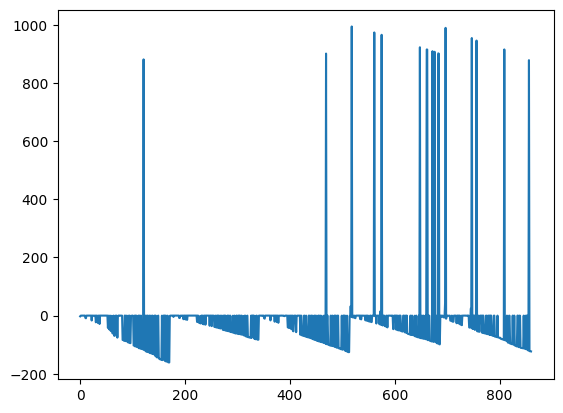

In [86]:
import matplotlib.pyplot as plt
plt.plot(deltaList)

File-level analysis

In [67]:
manualStory1DFSel = manualStory1DF.dropna()
print(manualStory1DFSel.index)
manualStory1SelMatrix = manualStory1DFSel.to_numpy()
manualStory1DFSelIndex = list(manualStory1DFSel.index)

fileScoresManual = [np.sum(x) for x in manualStory1SelMatrix]

Index(['SMVCS', 'XSWMB', 'YVBRP', 'Z2BYD', 'ZDPNZ'], dtype='object')


In [66]:
asrStory1DFSel = asrStory1DF.dropna().loc[manualStory1DFSelIndex,:]
print(asrStory1DFSel.index)
asrStory1SelMatrix = asrStory1DFSel.to_numpy()

fileScoresAutomatic = [np.sum(x) for x in asrStory1SelMatrix]

Index(['SMVCS', 'XSWMB', 'YVBRP', 'Z2BYD', 'ZDPNZ'], dtype='object')


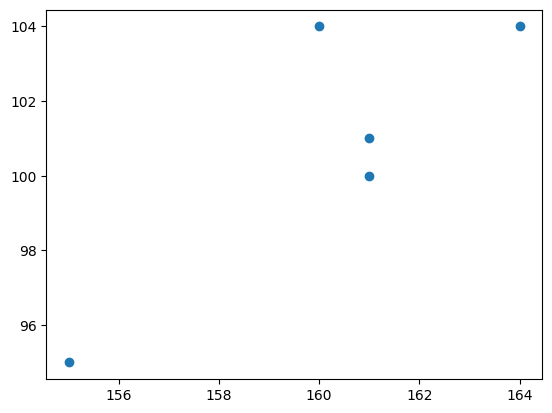

-411.54672897196264


In [70]:
# importing package 
import matplotlib.pyplot as plt 
  
# create data 
x = fileScoresManual
y = fileScoresAutomatic
  
# plot line 
plt.scatter(x, y) 
plt.show()

from sklearn.metrics import r2_score
print(r2_score(x,y))


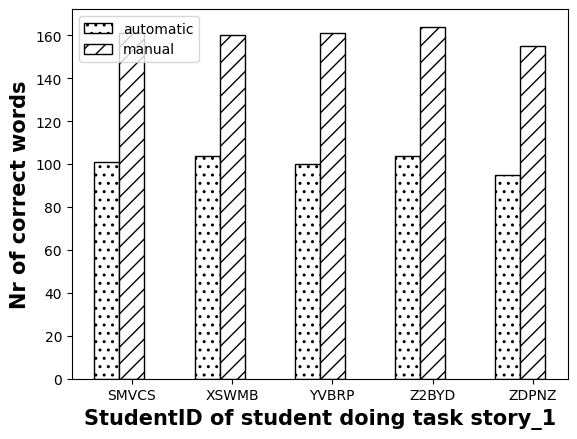

In [103]:
# importing package 
import matplotlib.pyplot as plt 
  
# create data 
x = list(asrStory1DFSel.index)
y1 = fileScoresAutomatic
y2 = fileScoresManual

# Set position on horizontal axis
barWidth=0.25
br1 = np.arange(len(y1)) 
br2 = [x + barWidth for x in br1]
  
# plot line 
plt.bar(br1, y1, color='white', edgecolor='black', width = barWidth, label='automatic', hatch='..') # Automatic Total score for each file
plt.bar(br2, y2, color='white', edgecolor='black', width = barWidth, label='manual', hatch='//') # Manual Total score for each file
# plt.plot(x, y2, color='orange') # Manual Total score for each file

# Adding Xticks 
plt.xlabel('StudentID of student doing task story_1', fontweight ='bold', fontsize = 15) 
plt.ylabel('Nr of correct words', fontweight ='bold', fontsize = 15) 
plt.xticks([r + barWidth for r in range(len(y1))], list(asrStory1DFSel.index))

plt.legend()
plt.show()


Incorrect prompt analysis

- Are there prompts that are always incorrect?

In [17]:
manualStory2Clean, asrStory2Clean = removeNANvalues(manualStory2, asrStory2)
matthews_corrcoef(manualStory2Clean, asrStory2Clean)

Nr values with NAN: 35460 35460
Nr values without NAN: 1080 1080


0.3809032889086343

In [18]:
manualStory3Clean, asrStory3Clean = removeNANvalues(manualStory3, asrStory3)
matthews_corrcoef(manualStory3Clean, asrStory3Clean)

Nr values with NAN: 33884 33884
Nr values without NAN: 1032 1032


0.29877687613706